In [42]:
import polars as pl
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
import json
from collections import defaultdict

draw_rxn = lambda x: display(SVG(draw_reaction(x)))
draw_mol = lambda x: display(SVG(draw_molecule(x)))

In [17]:
rc0_rules = pl.read_csv(
    "/home/stef/enz_rxn_data/artifacts/rules/rc_plus_0_rules.csv",
    separator=",",
)
rc0_rules.head()

id,smarts,ni_ids
i64,str,str
0,"""[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[…","""['rule0631']"""
1,"""[#16:1].[#16:2].[#8:3]=[#16:4]…","""['rule0967']"""
2,"""[#6:1]-[#16+:2].[#7:3]:[#6:4]-…","""['rule0422']"""
3,"""[#6:1].[#6:2]1:[#6:3]-[#7:4]-[…","""['rule1019']"""
4,"""[#6:1]-[#7+:2]:[#6:3].[#6:4]=[…","""['rule0813']"""


In [18]:
ni = pl.read_csv(
    "/home/stef/enz_rxn_data/artifacts/rules/ni_min_rules.tsv",
    separator="\t",
)
ni.head()

Name,Reactants,SMARTS,Products,Comments
str,str,str,str,str
"""rule0001""","""Any;Any""","""[#6:1]-[#8:2].[#8:3]>>[#6:1]-[…","""Any;Any""","""A0A060PLD9;A0A0P0YNP7;A0A0P9RZ…"
"""rule0002""","""Any;NAD_CoF""","""[#6:1]-[#8:2].[#6:3]1:[#6:4]:[…","""NADH_CoF;Any""","""A0A023RBJ1;A0A060KZ16;A0A060TB…"
"""rule0003""","""NADH_CoF;Any""","""[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[…","""Any;NAD_CoF""","""A0A023RBJ1;A0A060KZ16;A0A060TB…"
"""rule0004""","""Any;NADH_CoF;O2""","""[#6:1].[#6:2]1=[#6:3]-[#7:4]-[…","""Any;NAD_CoF;WATER""","""A0A1P8W705;A0A250DUW2;A1Z745;A…"
"""rule0005""","""Any;NAD_CoF;WATER""","""[#6:1]-[#8:2].[#6:3]1:[#6:4]:[…","""Any;NADH_CoF;O2""","""A0A1P8W705;A0A250DUW2;A1Z745;A…"


In [3]:
rc0_maps = pl.read_parquet(
    "/home/stef/enz_rxn_data/data/interim/pathway/mappings_sprhea_240310_v3_mapped_no_subunits_x_rc_plus_0_rules.parquet"
)
rc0_maps.head()

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""0""","""NC(CCC=O)C(=O)O.NC(=O)c1ccc[n+…","""[NH2:7][CH:6]([CH2:5][CH2:3][C…","""[#6:1].[#6:2]1:[#6:3]:[#6:4]:[…","""4;3,4,5,6,7,47;2>>4,6;3,4,5,45…",819
"""1""","""CC(O)C(O)C(O)C(O)C(=O)O>>CC(O)…","""[CH3:7][CH:5]([OH:8])[CH:4]([O…","""([#6:1]-[#8:2].[#6:3]-[#8:4])>…","""5,6,7,8>>5,6,7;0""",402
"""3""","""CSCCC(=O)C(=O)O.O=CO>>CSCCC(=O…","""[CH3:9][S:8][CH2:7][CH2:5][C:3…","""[#6:1]=[#8:2].[#6:3]=[#8:4]>>[…","""6,7;1,0>>6,8;0,1""",31
"""5""","""Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(…","""[NH2:75][c:73]1[n:71][c:69]2[c…","""[#6:1]-[#8:2].[#8:3]>>[#6:1]-[…","""21,20;37>>37,38;19""",517
"""5""","""Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(…","""[NH2:75][c:73]1[n:71][c:69]2[c…","""([#8:1].[#6:2]-[#8:3]).[#6:4]-…","""31,21,20;27,26>>26,27,37,38;19""",848


In [28]:
with open("/home/stef/enz_rxn_data/data/raw/pathway/sprhea_240310_v3_mapped_no_subunits.json", 'r') as f:
    rhea = json.load(f)

In [13]:
srt_idx = rc0_maps.group_by("rule_id").len().sort("len", descending=False)["rule_id"].to_list()

In [23]:
i = 0
eg = rc0_maps.filter(
    pl.col("rule_id") == srt_idx[i],
)
eg

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""7076""","""Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=…","""[NH2:27][c:25]1[n:26][cH:24][n…","""[#16:1].[#6:2]-[#8:3]-[#6:4]-[…","""14;27,26,24,23>>0,1;0,1;23""",551


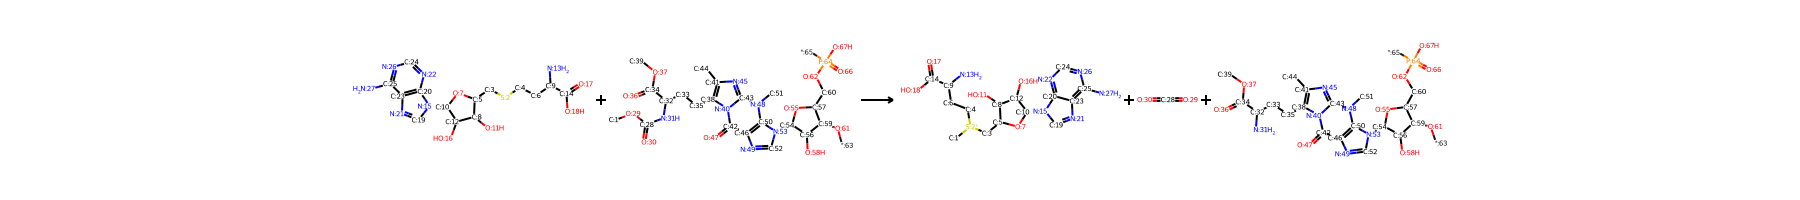

In [24]:
draw_rxn(eg[0, "am_smarts"])

In [26]:
rc0_maps.filter(
    pl.col("rxn_id") == "7076"
)

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""7076""","""Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=…","""[NH2:27][c:25]1[n:26][cH:24][n…","""[#16:1].[#6:2]-[#8:3]-[#6:4]-[…","""14;27,26,24,23>>0,1;0,1;23""",551


In [20]:
rc0_rules.filter(
    pl.col("id") == 551
)

id,smarts,ni_ids
i64,str,str
551,"""[#16:1].[#6:2]-[#8:3]-[#6:4]-[…","""['rule0904']"""


In [29]:
rhea["7076"]

{'smarts': 'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O.*OC1C(COP(*)(=O)O)OC(n2cnc3c(=O)n4c(CCC(NC(=O)OC)C(=O)OC)c(C)nc4n(C)c32)C1O>>C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.O=C=O.*OC1C(COP(*)(=O)O)OC(n2cnc3c(=O)n4c(CCC(N)C(=O)OC)c(C)nc4n(C)c32)C1O',
 'min_rule': 'rule0904',
 'imt_rules': None,
 'smi2name': {'*OC1C(COP(*)(=O)O)OC(n2cnc3c(=O)n4c(CCC(NC(=O)OC)C(=O)OC)c(C)nc4n(C)c32)C1O': 'wybutosine residue',
  'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O': 'S-adenosyl-L-homocysteine',
  '*OC1C(COP(*)(=O)O)OC(n2cnc3c(=O)n4c(CCC(N)C(=O)OC)c(C)nc4n(C)c32)C1O': '7-[(3S)-(3-amino-3-methoxycarbonyl)propyl]wyosine residue',
  'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O': 'S-adenosyl-L-methionine',
  'O=C=O': 'CO2'},
 'enzymes': [{'uniprot_id': 'Q8BYR1',
   'sequence': 'MGPRGRQRRAGTVQSTNDSSSLSKRSLAAHGYVRDPFAALLVPGPVRRTPLIHRGYYVRARAVRHCVRAFLELTSALPSRTRAQILSLGSGSDSLYFRLKAAGLLARAAVWEVDFPDVSRLKAERIEETPELRAQTGPFKIGDSASSLCFESADYRILGADLRELQRLGEALDGAGLDATSPTLLLAEAVLTYLEPSSATALIAWAAQRFPDALFV

In [30]:
rc0_maps.filter(
    pl.col("rule_id") == 13,
)

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""15268""","""CCC(C(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:3][CH2:5][CH:6]([C:1](=[O…","""([#6:1].[#8:2]=[#6:3]-[#8:4])>…","""0,4,3,5>>0,3,4,5""",13
"""16573""","""CC(CC(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:3][CH:5]([CH2:6][C:1](=[O…","""([#6:1].[#8:2]=[#6:3]-[#8:4])>…","""0,4,3,5>>0,3,4,5""",13


In [31]:
rc0_maps.filter(
    pl.col("rxn_id") == "15268"
)

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""15268""","""CCC(C(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:3][CH2:5][CH:6]([C:1](=[O…","""([#6:1].[#8:2]=[#6:3]-[#8:4])>…","""0,4,3,5>>0,3,4,5""",13
"""15268""","""CCC(C(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:4][CH2:2][CH:1]([C:5](=[O…","""([#6:1].[#6:2]-[#6:3])>>([#6:2…","""1,2,6>>1,2,6""",181
"""15268""","""CCC(C(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:1][CH2:3][CH:2]([C:4](=[O…","""[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[…","""0,1,2,3>>0,1,2,3""",948


In [39]:
rc0_maps.filter(
    pl.col("rxn_id") == "16573"
)

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""16573""","""CC(CC(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:3][CH:5]([CH2:6][C:1](=[O…","""([#6:1].[#8:2]=[#6:3]-[#8:4])>…","""0,4,3,5>>0,3,4,5""",13
"""16573""","""CC(CC(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:7][CH:1]([CH2:2][C:4](=[O…","""([#6:1].[#6:2]-[#6:3])>>([#6:2…","""2,1,6>>1,2,6""",181
"""16573""","""CC(CC(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:1][CH:3]([CH2:2][C:4](=[O…","""[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[…","""0,1,2,3>>0,1,2,3""",948


In [38]:
rc0_rules.filter(
    pl.col("id") == 948,
)['smarts'][0]

'[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6:2]-[#6:4]'

In [43]:
least_popular_rules

rule_id,len
i64,u32
423,1
551,1
24,1
929,1
950,1
…,…
849,568
139,568
637,1762


In [45]:
least_popular_rules = rc0_maps.group_by("rule_id").len().sort(
    "len", descending=False
).filter(
    pl.col("len") <= 5
)
redundant_rules = set()
for row in least_popular_rules.iter_rows(named=True):
    mapped_rxns = rc0_maps.filter(pl.col("rule_id") == row["rule_id"])["rxn_id"].to_list()
    other_counts = []
    for rxn in mapped_rxns:
        other_rules = rc0_maps.filter(pl.col("rxn_id") == rxn)["rule_id"].to_list()
        other_counts.append(len(other_rules))
    if all([x > 1 for x in other_counts]):
        redundant_rules.add(row["rule_id"])

In [47]:
len(redundant_rules)

36

In [48]:
redundant_rules

{13,
 35,
 53,
 66,
 84,
 109,
 133,
 173,
 216,
 219,
 248,
 275,
 282,
 296,
 311,
 326,
 383,
 440,
 474,
 490,
 558,
 617,
 632,
 659,
 677,
 691,
 720,
 733,
 745,
 789,
 817,
 861,
 891,
 930,
 941,
 950}

In [49]:
rc0_maps.filter(
    pl.col("rule_id") == 35,
)

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""1519""","""*C(=O)NC1C(O)OC(COP(=O)(O)O)C(…","""[*:18][C:17](=[O:19])[NH:16][C…","""[#6:1]-[#8:2]-[#6:3]-[#8:4]>>(…","""8,7,5,6>>5,6,11,12""",35
"""6283""","""O=C(O)C1(O)C=Cc2ccccc2O1>>O=C(…","""[O:13]=[C:12]([OH:14])[C:3]1([…","""[#6:1]-[#8:2]-[#6:3]-[#8:4]>>(…","""12,13,3,4>>3,4,12,13""",35
"""10624""","""CC(=O)NC1C(O)CC(O)(C(=O)O)OC1C…","""[CH3:17][C:13](=[O:18])[NH:9][…","""[#6:1]-[#8:2]-[#6:3]-[#8:4]>>(…","""14,13,8,9>>8,9,13,14""",35


In [52]:
rc0_maps.filter(
    pl.col("rxn_id") == "1519"
)["rule"][0]

'[#6:1]-[#8:2]-[#6:3]-[#8:4]>>([#6:1]-[#8:4].[#6:3]=[#8:2])'

In [53]:
rc0_maps.filter(
    pl.col("rxn_id") == "1519"
)["rule"][1]

'[#8:1]-[#6:2]-[#8:3]>>([#8:1].[#6:2]=[#8:3])'

In [54]:
for rule in redundant_rules:
    print(rc0_rules.filter(pl.col("id") == rule)["smarts"][0])

[#6:1]-[#6:2]-[#6:3]-[#8:4].[#6:5]1:[#6:6]:[#6:7]:[#6:8]:[#7+:9]:[#6:10]:1.[#8:11]>>[#6:1]-[#6:3]-[#6:2].[#6:5]1=[#6:10]-[#7+0:9]-[#6:8]=[#6:7]-[#6:6]-1.[#8:11]=[#8:4]
([#6:1].[#8:2]=[#6:3]-[#8:4])>>([#6:3].[#8:4]=[#6:1]-[#8:2])
[#6:1]=[#6:2]-[#8:3].[#6:4]=[#8:5].[#8:6]>>[#8:3].[#8:6]=[#6:2]-[#6:1]-[#6:4]-[#8:5]
([#6:1].[#6:2]=[#8:3])>>([#6:2].[#6:1]=[#8:3])
[#6:1]=[#6:2]-[#8:3]-[#15:4]-[#8:5].[#8:6]>>[#6:1]-[#6:2]=[#8:5].[#8:3]-[#15:4]-[#8:6]
[#6:1].[#8:2]=[#6:3]-[#6:4]-[#8:5]>>[#6:1]-[#6:3]-[#8:2].[#6:4]=[#8:5]
[#6:1]-[#6:2]-[#6:3].[#6:4]1=[#6:5]-[#7:6]-[#6:7]=[#6:8]-[#6:9]-1.[#8:10]=[#8:11]>>[#6:1]-[#6:3]-[#6:2]-[#8:10].[#6:4]1:[#6:9]:[#6:8]:[#6:7]:[#7+:6]:[#6:5]:1.[#8:11]
[#6:1]-[#8:2]-[#6:3]-[#8:4]>>([#6:1]-[#8:4].[#6:3]=[#8:2])
[#6:1]-[#8:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[#6:7]-[#6:8]-1.[#8:9]=[#8:10]>>[#6:3]1:[#6:8]:[#6:7]:[#6:6]:[#7+:5]:[#6:4]:1.[#6:1]=[#8:2].[#8:10].[#8:9]
[#8:1]-[#6:2]1:[#6:3]:[#6:4]:[#6:5]:[#6:6]:[#6:7]:1.[#8:8]=[#8:9]>>[#8:8]=[#6:3]-[#6:2]=[#6:7]-[#6:6]=[#6:

In [57]:
res_map = pl.read_parquet(
    "/home/stef/enz_rxn_data/data/processed/pathway/mapped_sprhea_240310_v3_mapped_no_subunits_x_rc_plus_0_rules.parquet"
)
res_map.filter(
    pl.col("rule_id") == 13
)

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
